In [1]:
# Tensorflow Error Fix
import tensorflow



In [2]:
import gym
env = gym.make('SpaceInvaders-v0')
env.reset()
for _ in range(1000):
    env.step(env.action_space.sample())
    env.render('human')
env.close()  # https://github.com/openai/gym/issues/893

In [3]:
import random
import cv2
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow.keras as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
plt.ion()

In [4]:
#Wrapper Class for the Gym Pong Environment
class Pong:
    def __init__(self):
        self.env = gym.make("PongNoFrameskip-v4")
        self.ACTION_SPACE = [0, 2, 3]
        self.env.reset()
        self.SKIP_FRAMES = 8
        self.NEUTRAL_ACTION = 0
        self.FIRE_ACTION = 1
        self.framecount = 0

    def reset(self):
        self.env.reset()
        o, _, _, _ = self.env.step(self.FIRE_ACTION)
        sum = 0
        while sum < 70:
            o, _, _, _ = self.env.step(self.NEUTRAL_ACTION)
            o = self.prep_o(o)
            sum = np.sum(o)
        self.framecount = 0
        return o

    def neutral_step(self):
        return self.step(self.NEUTRAL_ACTION)

    def step(self, action):
        rf = 0
        self.framecount += 1
        done = False
        for _ in range(self.SKIP_FRAMES):
            o, r, d = self.step_raw(self.ACTION_SPACE[action])
            if not r == 0:
                rf = r
                done = True
        return self.prep_o(o), rf, done

    def step_raw(self, action):
        o, r, d, _ = self.env.step(action)
        return o, r, d

    def o_imshow(self, o):
        o = o * 255.0
        o = o.astype(np.uint8)
        cv2.imshow('o', o)
        cv2.waitKey(20)

    def prep_o(self, o):
        o = o[35:195, :]
        o = cv2.cvtColor(o, cv2.COLOR_RGB2GRAY)
        ret, o = cv2.threshold(o, 100, 255, cv2.THRESH_BINARY)
        o = cv2.resize(o, (80, 80))
        o = o.astype(np.float64).reshape((80, 80, 1))
        o = o / 255.0
        return o

    def render(self):
        self.env.render()


In [5]:
from tqdm import tqdm

#RL Agent Class
class Agent:
    def __init__(self):
        self.N_FRAMES = 4
        self.framebuffer = deque(maxlen=self.N_FRAMES)
        self.pong = Pong()
        self.pong.reset()
        self.EXPERIENCE_SIZE = 8192
        self.experience = deque(maxlen=self.EXPERIENCE_SIZE)
        self.stepcount = 0
        self.LEARNING_RATE = 0.0001
        self.make_models()
        self.DISCOUNT = 0.95
        self.EPSILON_MAX = 1.0
        self.epsilon = self.EPSILON_MAX
        self.EPSILON_MIN = 0.02
        self.EPSILON_DECAY_STEPS = 10000
        self.BATCH_SIZE = 32
        self.fit_epoch_count = 1
        self.UPDATE_TARGET_EVERY = 1000

    def update_epsilon(self):
        self.stepcount += 1
        self.epsilon = max(self.EPSILON_MAX - (self.stepcount * (self.EPSILON_MAX / self.EPSILON_DECAY_STEPS)),
                           self.EPSILON_MIN)

    def play(self, state):
        if random.random() < self.epsilon:
            retval = random.choice(range(len(self.pong.ACTION_SPACE)))
        else:
            retval = np.argmax(self.running_model.predict(np.asarray([state]))[0])
        self.update_epsilon()
        return retval

    def play_random_game(self):
        o = self.pong.reset()
        for _ in range(self.N_FRAMES):
            self.framebuffer.append(o)
            o, _, _ = self.pong.neutral_step()
        done = False
        while not done:
            old_state = self.make_state()
            action = random.choice(range(len(self.pong.ACTION_SPACE)))
            o_new, r, done = self.pong.step(action)
            self.framebuffer.append(o_new)
            new_state = self.make_state()
            self.experience.append((old_state, action, r, new_state, done))

    def make_state(self):
        return np.concatenate(self.framebuffer, axis=-1)

    def validate_experience(self):
        old_state, action, reward, new_state, done = random.choice(self.experience)
        fig, axs = plt.subplots(2, 4)
        for i in range(2):
            if i == 0:
                state = old_state
            else:
                state = new_state
            for j in range(self.N_FRAMES):
                axs[i][j].imshow(state[:, :, j])
        plt.show()

    def play_and_learn(self, numgames):
        game_lengths = []
        epsilons = []
        losses = []
        rewards = []
        fig, axs = plt.subplots(2, 2)
        axs[0][0].set_title("Game Length")
        axs[0][1].set_title("Epsilon")
        axs[1][0].set_title("Ultimate Reward")
        axs[1][1].set_title("Mean DQN Loss")
        plt.subplots_adjust(hspace=0.8, wspace=0.3)
        for ep in tqdm(range(numgames)):                
            game_losses = []
            o = self.pong.reset()
            for _ in range(self.N_FRAMES):
                self.framebuffer.append(o)
                o, _, _ = self.pong.neutral_step()
            done = False
            while not done:
                self.pong.render()
                old_state = self.make_state()
                action = self.play(old_state)
                o_new, r, done = self.pong.step(action)
                self.framebuffer.append(o_new)
                new_state = self.make_state()
                self.experience.append((old_state, action, r, new_state, done))
                ls = self.experience_replay()[0]
                game_losses.append(ls)
            rewards.append(r)
            losses.append(sum(game_losses) / len(game_losses))
            game_lengths.append(self.pong.framecount)
            epsilons.append(self.epsilon)
            axs[0][0].plot(game_lengths)
            axs[0][1].plot(epsilons)
            axs[1][0].plot(rewards)
            axs[1][1].plot(losses)
            plt.show()
            plt.pause(0.01)
        return game_lengths

    def process_batch(self, batch):
        old_states = [x for x, _, _, _, _ in batch]
        new_states = [x for _, _, _, x, _ in batch]
        old_rewards = self.running_model.predict(np.asarray(old_states))
        new_rewards = self.target_model.predict(np.asarray(new_states))
        for i, (old_state, action, reward, new_state, done) in enumerate(batch):
            add_q = 0
            if not done:
                add_q = self.DISCOUNT * np.amax(new_rewards[i])
            q_value = reward + add_q
            old_rewards[i][action] = q_value
        return np.asarray(old_states), old_rewards

    def experience_replay(self):
        batch = random.choices(self.experience, k=32)
        x, y = self.process_batch(batch)
        hist = self.running_model.fit(x, y, verbose=False)
        self.fit_epoch_count += 1
        if self.stepcount % self.UPDATE_TARGET_EVERY == 0:
            self.target_model.set_weights(self.running_model.get_weights().copy())
        return hist.history['loss']

    def make_models(self):
        self.running_model = tf.Sequential()
        self.target_model = tf.Sequential()
        self.add_layers_to(self.running_model)
        self.add_layers_to(self.target_model)
        self.running_model.compile(optimizer=Adam(learning_rate=self.LEARNING_RATE), loss='mse')
        self.running_model.summary()

    def add_layers_to(self, model: tf.Sequential):
        layerlist = [
            Conv2D(32, 8, 4, use_bias=False, activation='relu', input_shape=(80, 80, self.N_FRAMES)),
            Conv2D(16, 4, 2, use_bias=False, activation='relu'),
            Conv2D(16, 3, 1, use_bias=False, activation='relu'),
            Flatten(),
            Dense(512, use_bias=False, activation='relu'),
            Dense(len(self.pong.ACTION_SPACE), use_bias=False, activation='linear')
        ]
        [model.add(x) for x in layerlist]

  0%|          | 0/10000 [00:00<?, ?it/s]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 19, 19, 32)        8192      
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          8192      
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 16)          2304      
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 512)               294912    
                                                                 
 dense_1 (Dense)             (None, 3)                 1536      
                                                                 
Total params: 315,136
Trainable params: 315,136
Non-trai

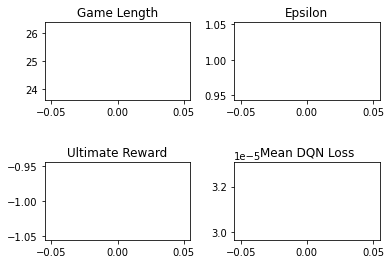

  0%|          | 22/10000 [01:11<8:46:43,  3.17s/it] 

KeyboardInterrupt: 

In [6]:
#Begin Training
a = Agent()
a.play_and_learn(10000)

